In [19]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Pauli, pauli_basis, SuperOp, PTM, Operator
from qiskit.circuit.library import CXGate, CZGate, HGate, SGate, SdgGate
from random import choice, choices
from itertools import product, permutations, cycle
from scipy.optimize import curve_fit, nnls
from matplotlib import pyplot as plt
import numpy as np
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeVigoV2
from qiskit.providers.aer import Aer
from typing import List, Tuple, Dict
from qiskit.providers.backend import Backend, BackendV1, BackendV2
from sympy import singularities
from collections import namedtuple
import scipy as sc

plt.rcParams["figure.figsize"] = (6.4,4.0)

In [26]:
QUBIT = int
DOUBLE_GATE = 2
SINGLE_GATE = 1
NUM_BASES = 9
Layer = namedtuple("Layer", ['qubits','two_qubit_gates','single_qubit_gates'])

class LearningProcedure:
    def __init__(self, layer : Layer, backend):
        self.qubits = layer.qubits
        two_qubit_gates = layer.two_qubit_gates
        single_qubit_gates = layer.single_qubit_gates
        unmap = lambda i: self.qubits.index(i)

        self.backend = backend
        self.two_qubit_gates = [(gate,tuple(unmap(s) for s in support)) for gate,support in two_qubit_gates]
        self.single_qubit_gates = [unmap(q) for q in single_qubit_gates]
        self.n = len(self.qubits)

        adjacency_matrix = self.adjacency_matrix(self.qubits, backend)
        self.bases = self.pauli_bases(adjacency_matrix)
        self.conjugation = self.conjugation_rules()
        self.model_paulis = self.model_terms(adjacency_matrix)
        self.pairs = [(p,self.commute_layer(p)) for p in self.model_paulis]


    def adjacency_matrix(self, qubits, backend):

        try:
            backend_edges = backend.coupling_map.get_edges()
        except:
            print("Extracting coupling map failed, retrying with Backend V1")
            try:
                backend_edges = backend.configuration().coupling_map
            except:
                raise Exception("Extraction of coupling map failed")
        
        coupling_map = [(q1, q2) for q1,q2 in backend_edges if q1 in qubits and q2 in qubits]

        #remap qubits so that layer is sequential
        unmap = lambda i: qubits.index(i)
        verts = [unmap(qubit) for qubit in qubits]
        edges = [(unmap(qubit1), unmap(qubit2)) for qubit1,qubit2 in coupling_map]

        #adjacency matrix has a 1 at i,j if i and j are connected, 0 otherwise
        adjacency_matrix = [[0 for i in verts] for j in verts] 
        for (vert1,vert2) in edges:
            adjacency_matrix[vert1][vert2] = 1
            adjacency_matrix[vert2][vert1] = 1

        return adjacency_matrix

    def pauli_bases(self, adjacency_matrix):
        n = self.n
        verts = range(n)

        bases = [['I']*n for i in range(NUM_BASES)]
        remaining = list(verts) 

        while remaining:
            vertex = remaining.pop(0)
            #copied from Fig. S3 in van den Berg
            orderings = {"XXXYYYZZZ":"XYZXYZXYZ",
                                "XXXYYZZZY":"XYZXYZXYZ",
                                "XXYYYZZZX":"XYZXYZXYZ",
                                "XXZYYZXYZ":"XYZXZYZYX",
                                "XYZXYZXYZ":"XYZZXYYZX"}
            children = [i for i,e in enumerate(adjacency_matrix[vertex]) if e == 1]
            predecessors = [c for c in children if c not in remaining]

            match len(predecessors):
                #trivial if no predecessors
                case 0:
                    cycp = cycle("XYZ")
                    for i,_ in enumerate(bases):
                        bases[i][vertex] = next(cycp)
                #Choose p1:"XXXYYYZZZ" and p2:"XYZXYZXYZ" if one predecessor
                case 1:
                    pred = predecessors[0]
                    #store permutation of indices so that predecessor has X,X,X,Y,Y,Y,Z,Z,Z
                    bases = list(zip(*sorted(zip([p[pred] for p in bases], bases))))[1]
                    cycp = cycle("XYZ")
                    for i,_ in enumerate(bases):
                        bases[i][vertex] = next(cycp)
                case 2:
                    pred0,pred1 = predecessors
                    bases = list(zip(*sorted(zip([p[pred0] for p in bases], bases))))[1]
                    #list out string with permuted values of predecessor 2
                    substr = [p[pred0] for p in bases]
                    #match predecessor two with a permutation of example_orderings
                    reordering = ""
                    for perm in permutations("XYZ"):
                        p_substr = "".join(["XYZ"[perm.index(p)] for p in p_substr])
                        if p_substr in orderings:
                            current = orderings[p_substr] 
                            for i,p in enumerate(current):
                                bases[i][vertex] = p
                            break
                case _: #processor needs to have connectivity so that there are <= 2 predecessors
                    raise Exception("Three or more predecessors encountered")

        print("Pauli bases were chosen:",["".join(string[::-1]) for string in bases])

        return [Pauli("".join(string[::-1])) for string in bases]

    def model_terms(self, adjacency_matrix):
        n = self.n
        model_terms = set()
        identity = Pauli("I"*n)    

        #get all single-weight paulis
        for i in range(n):
            for op in pauli_basis(1, pauli_list = True):
                pauli = identity.copy()
                pauli[i] = op
                model_terms.add(pauli)
                
        #get all weight-two paulis on with suport on nieghboring qubits
        for vert1,link in enumerate(adjacency_matrix):
            for vert2,val in enumerate(link[:vert1]):
                if val == 1:
                    for p1, p2 in pauli_basis(2, pauli_list = True):
                        pauli = identity.copy()
                        pauli[vert1] = p1
                        pauli[vert2] = p2
                        model_terms.add(pauli)

        model_terms.remove(identity)
        print("The terms included in the model are the following:", [p.to_label() for p in model_terms])
        return list(model_terms)
    
    def conjugation_rules(self):

        def nophase(pauli):
            return Pauli((pauli.z, pauli.x))
        #given a pauli matrix, get the corresponding name (in terms of I,X,Y,Z)
        def get_name(pauli):
            for p in pauli_group:
                if Operator(p).equiv(Operator(pauli)):
                    return p

        #conjugate a pauli with a clifford
        def conjugate(p, c):
            return nophase(Pauli(get_name(c @ p.to_matrix() @ np.conjugate(np.transpose(c)))))

        conjugation = {'cx':{}, 'cz':{}}
        pauli_group = pauli_basis(2, pauli_list = True)
        gates = [('cx',CXGate()), ('cz', CZGate())]
        for p,(g_name, g) in product(pauli_group, gates):
            conjugation[g_name][p] = conjugate(p, g.to_matrix())
        
        return conjugation

    def commute_layer(self, pauli):

        def nophase(pauli):
            return Pauli((pauli.z, pauli.x))

        two_qubit_gates = self.two_qubit_gates
        p_prime = pauli.copy()
        for (gate,support) in two_qubit_gates:
            p = nophase(p_prime[support[1]].tensor(p_prime[support[0]]))
            pp = self.conjugation[gate][p]
            for i,s in enumerate(support):
                p_prime[s] = pp[i]

        return nophase(p_prime)

    def instance(
        self, 
        prep_basis : Pauli, 
        meas_basis : Pauli, 
        noise_repetitions : int, 
        transpiled=True
        ):

        n = self.n
        backend = self.backend
        two_qubit_gates = self.two_qubit_gates
        single_qubit_gates = self.single_qubit_gates
        qubits = self.qubits
        circ = QuantumCircuit(n,n) #storing the final circuit

        def nophase(pauli):
            return Pauli((pauli.z, pauli.x))

        #get preparation ops from desired basis 
        def prep(basis, qubit, qc):
            if basis.equiv(Pauli("X")):
                qc.h(qubit) 
            elif basis.equiv(Pauli("Y")):
                qc.h(qubit)
                qc.s(qubit)

        #apply operators to a quantum circuit to measure in desired pauli basis
        def meas(basis, qubit, qc):
            if basis.equiv(Pauli("X")):
                qc.h(qubit)
            elif basis.equiv(Pauli("Y")):
                qc.sdg(qubit)
                qc.h(qubit)

        #apply a two-qubit gate to the circuit
        def apply_gate(two_qubit_gate, qc):
            gate,support = two_qubit_gate
            if gate == 'cx':
                qc.cx(*support)
            if gate == 'cz':
                qc.cz(*support)
        
        pauli_frame = choice(pauli_basis(n, pauli_list = True))

        #apply the prep and twirling operators to the circuit
        for qubit,(p,b) in enumerate(zip(pauli_frame,prep_basis)):
            prep(b,qubit,circ)
            circ.append(p, [qubit])

        circ.barrier()
        
        #apply repetitions of noise, including basis-change gates when needed
        for i in range(noise_repetitions):
            for gate in two_qubit_gates:
                apply_gate(gate, circ)

            twirl = choice(pauli_basis(n, pauli_list = True))
            for i,p in enumerate(twirl):
                circ.append(p,[i])

            pauli_frame = self.commute_layer(pauli_frame)
            pauli_frame = nophase(pauli_frame.compose(twirl))
            
            circ.barrier()

        #choose sstring of bit flips for readout twirling
        rostring = "".join(choices(['I','X'], k=n))

        for q,(p,b,r) in enumerate(zip(pauli_frame, meas_basis, rostring)):
            circ.append(p, [q])
            meas(b, q, circ)
            if r == "X":
                circ.x(q)

        circ.barrier()

        if transpiled:
            circ = transpile(circ, backend, initial_layout = self.qubits, optimization_level = 1)
            for i,q in enumerate(qubits):
                circ.measure(q,i)
        else:
            for i in range(n):
                circ.measure(i,i)

        return circ, {
            "prep_basis":prep_basis,
                "meas_basis":meas_basis, 
                "depth":noise_repetitions, 
                "rostring":rostring[::-1],
                }

    def procedure(
        self,
        depths,
        samples,
        single_samples = None
    ):

        if isinstance(samples, int):
            samples = [samples]*len(depths)
        if not single_samples:
            single_samples = samples[0]

        self.depths = depths
        self.single_samples = single_samples

        def weight(pauli):
            return len([p for p in pauli if not p==Pauli("I")])
            
        pairs = self.pairs

        single_measurements = [(p1,p2) for (p1,p2) in pairs if p1 != p2 and weight(p1) == 1 and weight(p2) == 2]
        single_measurements += list(set([frozenset([p1,p2]) for p1,p2 in pairs if p1 != p2 and weight(p1) == weight(p2) == 2]))
        single_measurements = [list(s) for s in single_measurements]

        print("The following pairs require single measurements:", single_measurements)

        circuits = []
        metadatas = []
        bases = self.bases
        total = len(bases)*sum(samples)+len(single_measurements)*single_samples

        j=0
        for basis, (d,s) in product(bases, zip(depths,samples)):

            for i in range(s):
                circ, data = self.instance(
                    basis, 
                    basis, 
                    d, 
                    )

                j+=1
                print(j,"/",total, end='\r')
                circuits.append(circ)
                metadatas.append(dict(**data, type = "double"))
        
        for (pauli, pair), s in product(single_measurements, range(single_samples)):

            circ, data = self.instance(
                pair,
                pauli,
                1,
            )
            j+=1
            print(j,"/",total, end='\r')
            circuits.append(circ)
            metadatas.append({"type":"single", **data})

        print("Generated", len(circuits), "circuits")

        return circuits, metadatas
 
class ProcedureAnalysis:
    def __init__(self, layer, depths, single_samples, model_terms):
        self.n = len(layer.qubits)
        self.depths = depths
        self.single_samples = single_samples
        self.two_qubit_gates = layer.two_qubit_gates
        self.conjugation = self.conjugation_rules()
        self.model_terms = model_terms

    @classmethod
    def fromExperiment(cls, experiment):
        return cls(
            Layer(
                experiment.qubits,
                experiment.two_qubit_gates,
                experiment.single_qubit_gates,
            ),
            experiment.depths,
            experiment.single_samples,
            experiment.model_paulis
        )

    def conjugation_rules(self):

        def nophase(pauli):
            return Pauli((pauli.z, pauli.x))
        #given a pauli matrix, get the corresponding name (in terms of I,X,Y,Z)
        def get_name(pauli):
            for p in pauli_group:
                if Operator(p).equiv(Operator(pauli)):
                    return p

        #conjugate a pauli with a clifford
        def conjugate(p, c):
            return nophase(Pauli(get_name(c @ p.to_matrix() @ np.conjugate(np.transpose(c)))))

        conjugation = {'cx':{}, 'cz':{}}
        pauli_group = pauli_basis(2, pauli_list = True)
        gates = [('cx',CXGate()), ('cz', CZGate())]
        for p,(g_name, g) in product(pauli_group, gates):
            conjugation[g_name][p] = conjugate(p, g.to_matrix())
        
        return conjugation

    def commute_layer(self, pauli):

        def nophase(pauli):
            return Pauli((pauli.z, pauli.x))

        two_qubit_gates = self.two_qubit_gates
        p_prime = pauli.copy()
        for (gate,support) in two_qubit_gates:
            p = nophase(p_prime[support[1]].tensor(p_prime[support[0]]))
            pp = self.conjugation[gate][p]
            for i,s in enumerate(support):
                p_prime[s] = pp[i]

        return nophase(p_prime)

    def get_expectation(self, measurement, **metadata):
        total = 0
        counts = metadata['counts']
        pauli_weight = list(reversed([{Pauli("I"):'0'}.get(p,'1') for p in measurement]))
        rostring = metadata['rostring']
        for key in counts.keys():
            ro_adjusted = [{'0':'1','1':'0'}[bit] if flip=="X" else bit for bit,flip in zip(key,rostring)]
            sgn = sum([{('1','1'):1}.get((pauli_bit, key_bit), 0) for pauli_bit, key_bit in zip(pauli_weight, ro_adjusted)])
            total += (-1)**sgn*counts[key]
        return total/sum(counts.values())   

    def analyze(self, results, metadatas):

        def simultaneous_measurements(pauli):
            label = pauli.to_label()
            identity = "I"*self.n
            combos = zip(identity,label)
            sim_meas = []
            for pauli_string in product(*combos):
                sim_meas.append(Pauli("".join(pauli_string)))
            sim_meas.pop(0)
            return sim_meas

        depths = self.depths
        single_samples = self.single_samples
        #Sort into single and double measurements
        results_dict = [{**metadata, "counts":count} for metadata,count in zip(metadatas,results)]
        singles = []
        doubles = []
        for datum in results_dict:
            type = datum["type"]
            datum.pop("type")
            if type == "single":
                singles.append(datum)
            elif type == "double":
                doubles.append(datum)

        expfit = lambda x,a,b: a*np.exp(-b*x)

        #reorder by measurement basis
        basis_dict = {}
        for datum in doubles:
            basis = datum['prep_basis']
            depth = datum['depth']
            for pauli in simultaneous_measurements(basis):
                expectation = self.get_expectation(pauli, **datum)
                if not pauli in basis_dict:
                    basis_dict[pauli] = {"expectation":[0 for d in depths], "total":[0 for d in depths]}
                basis_dict[pauli]["expectation"][depths.index(depth)] += expectation
                basis_dict[pauli]["total"][depths.index(depth)] += 1

        self_conjugates = []
        pair_measurements = []
        for key in basis_dict.keys():
            for i,d in enumerate(depths):
                basis_dict[key]["expectation"][i] /= basis_dict[key]["total"][i]
            try:
                popt, pcov = curve_fit(expfit, depths, basis_dict[key]["expectation"], p0=[.9,.01])
                basis_dict[key]["fidelity"] = expfit(1,1,popt[1])
                basis_dict[key]["SPAM"] = popt[0]
            except:
                print("warning: fit did not converge for", key, "using 1")
                basis_dict[key]["fidelity"] = 1

            if key != self.commute_layer(key):
                pair_measurements.append(((key.to_label(),self.commute_layer(key).to_label()), basis_dict[key]["fidelity"]))
                basis_dict[key]["type"] = "pair"
            else:
                self_conjugates.append((key.to_label(), basis_dict[key]["fidelity"]))
                basis_dict[key]["type"] = "single"

        print("The following SPAM-free measurements were reconstructed:", self_conjugates)
        print("The following SPAM-free measurement pairs were constructed:", pair_measurements)

        singles_dict = {}

        for datum in singles:
            counts = datum['counts']
            prep_basis = datum['prep_basis']
            meas_basis = datum['meas_basis']

            if meas_basis not in singles_dict:
                singles_dict[meas_basis] = 0

            expectation = self.get_expectation(meas_basis, **datum)
            avg = basis_dict[meas_basis]['SPAM']
            fidelity = np.min([1.0,np.abs(expectation)/avg])
                
            singles_dict[meas_basis] += fidelity/single_samples

        for key in singles_dict.keys():
            basis_dict[key]['fidelity'] = singles_dict[key]
            basis_dict[key]['type'] = "single"

        print("The following degeneracy-lifting measurements were reconstructed:", list(zip([p.to_label() for p in singles_dict.keys()], singles_dict.values()))) 

        self.data = basis_dict 
        return self.data

    def fit_model(self):
        F1 = []
        F2 = []
        fidelities = []
        for key in self.model_terms:
            F1.append(key)
            fidelities.append(self.data[key]['fidelity'])
            if self.data[key]["type"] == "pair":
                pair = self.commute_layer(key)
                F2.append(pair)
            else:
                F2.append(key)
        
        sprod = lambda a,b: int(a.anticommutes(b))
        M1 = [[sprod(a,b) for a in self.model_terms] for b in F1]
        M2 = [[sprod(a,b) for a in self.model_terms] for b in F2]

        if np.linalg.matrix_rank(np.add(M1, M2)) != len(self.model_terms):
            raise Exception("Matrix is not full rank, something went wrong")

        coeffs,rnorm = sc.optimize.nnls(np.add(M1,M2), -np.log(fidelities))
        print("Model reconstructed with r-norm", rnorm)
        return list(zip(coeffs, self.model_terms))

    def graph(self, *paulis):
        expfit = lambda x,a,b: a*np.exp(-b*x)
        colcy = cycle("rgbcmk")
        for p in paulis:
            c = next(colcy)
            data = self.data[p]['expectation']
            popt, pcov = curve_fit(expfit, self.depths, data, p0=[.9,.01])
            xrange = np.linspace(0,np.max(self.depths))
            plt.plot(self.depths, data, c+"X")
            plt.plot(xrange, [expfit(x, *popt) for x in xrange], c)

        plt.show()

    def display(self, *paulis):
        ax = np.arange(len(paulis))
        fidelities = []
        for p in paulis:
            fid = self.data[p]['fidelity']
            if(self.data[p]['type'] == 'pair'):
                pair = self.commute_layer(p)
                fid = fid**2/self.data[pair]['fidelity']
            fidelities.append(fid)
        plt.bar(ax, [10*(1-f) for f in fidelities], .4,color='b')
        plt.xticks(ax, paulis)

In [27]:
layer = Layer([0,1],[('cx',(0,1))],[])
backend = FakeVigoV2()
sim = Aer.get_backend("qasm_simulator")

tglp = LearningProcedure(layer, backend)

Pauli bases were chosen: ['XX', 'YX', 'ZX', 'XY', 'YY', 'ZY', 'XZ', 'YZ', 'ZZ']
The terms included in the model are the following: ['XX', 'XZ', 'ZY', 'ZZ', 'YX', 'YY', 'XY', 'YI', 'XI', 'ZX', 'YZ', 'IX', 'ZI', 'IY', 'IZ']


In [28]:
from qiskit.providers.aer.noise import pauli_error
from random import random

errorgen = 4
errorops = choices(pauli_basis(2, pauli_list = True), k=errorgen)
errorprobs = [random()*.05/errorgen for op in errorops]
twoqubit_error = pauli_error([(op, p) for op,p in zip(errorops, errorprobs)]+[(Pauli("II"), 1-sum(errorprobs))])
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(twoqubit_error, ['cx','cz'])
singlequbit_error = pauli_error([(Pauli("X"), p_single[0]), (Pauli("Y"), p_single[1]), (Pauli("Z"), p_single[2]),(Pauli("I"), 1-sum(p_single))])

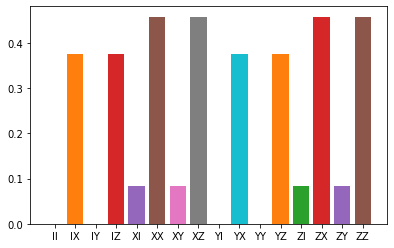

In [29]:

real_errors = {}
transfer_matrix = PTM(twoqubit_error.to_quantumchannel()).data
for i,pauli in enumerate(pauli_basis(2, pauli_list = True)):
    real_errors[pauli] = transfer_matrix[i][i]
    plt.bar(pauli.to_label(), 10*(1-transfer_matrix[i][i]).real)

In [36]:
circuits, metadatas = tglp.procedure([2,4,16], 100,100)

The following pairs require single measurements: [[Pauli('YI'), Pauli('YZ')], [Pauli('IX'), Pauli('XX')], [Pauli('ZI'), Pauli('ZZ')], [Pauli('IY'), Pauli('XY')], [Pauli('ZX'), Pauli('YY')], [Pauli('YX'), Pauli('ZY')]]
Generated 2400 circuits


In [37]:
analysis = ProcedureAnalysis.fromExperiment(tglp)

In [38]:
results = sim.run(circuits, shots=250, noise_model = noise_model).result().get_counts()

In [39]:
basis_dict = analysis.analyze(results, metadatas)

The following SPAM-free measurements were reconstructed: [('XI', 0.9914115081498172), ('IZ', 0.9623913861778013), ('XZ', 0.9549041747536877)]
The following SPAM-free measurement pairs were constructed: [(('IX', 'XX'), 0.9587459483860417), (('XX', 'IX'), 0.958755016199352), (('YI', 'YZ'), 0.9815960908726246), (('YX', 'ZY'), 0.9763824668535446), (('ZI', 'ZZ'), 0.9728093089014271), (('ZX', 'YY'), 0.9767763307715089), (('IY', 'XY'), 0.9956925487046561), (('XY', 'IY'), 0.9956867915499235), (('YY', 'ZX'), 0.9783633968373102), (('ZY', 'YX'), 0.9786379345313252), (('YZ', 'YI'), 0.9811839423351909), (('ZZ', 'ZI'), 0.9732486603171582)]
The following degeneracy-lifting measurements were reconstructed: [('YI', 1.0000000000000007), ('IX', 0.9655744910367344), ('ZI', 0.9921251149393925), ('IY', 0.9993523250987243), ('ZX', 0.9512525564885779), ('YX', 0.9620475286561361)]


In [40]:
def display(*paulis):
    fidelities = []
    fidelities_calculated = []
    ax = np.arange(len(tglp.model_paulis))
    for p in tglp.model_paulis:
        fid = basis_dict[p]['fidelity']
        if(basis_dict[p]['type'] == 'pair'):
            pair = tglp.commute_layer(p)
            fid = fid**2/basis_dict[pair]['fidelity']
        fidelities.append(fid)
        fidelities_calculated.append(real_errors[p])
    plt.bar(ax+.2, [10*(1-f) for f in fidelities], .4,color='b')
    plt.bar(ax-.2, [10*(1-f) for f in fidelities_calculated],.4, color='r')
    plt.xticks(ax, tglp.model_paulis)

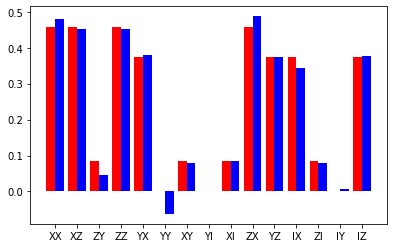

In [41]:
display(*tglp.model_paulis)

In [12]:
F1 = []
F2 = []
fidelities = []
for key in tglp.model_paulis:
    F1.append(key)
    fidelities.append(basis_dict[key]['fidelity'])
    if basis_dict[key]["type"] == "pair":
        pair = tglp.commute_layer(key)
        F2.append(pair)
    else:
        F2.append(Pauli("I"*tglp.n))

In [13]:
import scipy as sc
def fit_model():
    F1 = []
    F2 = []
    fidelities = []
    for key in tglp.model_paulis:
        F1.append(key)
        fidelities.append(basis_dict[key]['fidelity'])
        if basis_dict[key]["type"] == "pair":
            pair = tglp.commute_layer(key)
            F2.append(pair)
        else:
            F2.append(Pauli("I"*tglp.n))
    
    sprod = lambda a,b: int(a.anticommutes(b))
    M1 = [[sprod(a,b) for a in tglp.model_paulis] for b in F1]
    M2 = [[sprod(a,b) for a in tglp.model_paulis] for b in F2]
    coeffs,rnorm = sc.optimize.nnls(np.add(M1,M2), -np.log(fidelities))
    print(rnorm)
    return list(zip(coeffs, tglp.model_paulis))

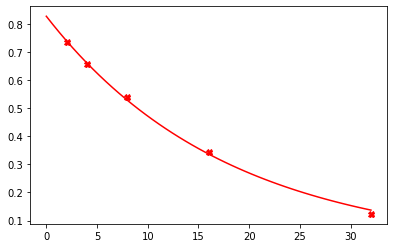

In [17]:
analysis.graph(Pauli("XX"))

Model reconstructed with r-norm 0.006876054509957111


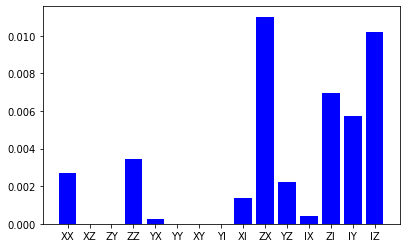

In [15]:
for coeff,term in analysis.fit_model():
        plt.bar(term.to_label(), coeff, color='b')